In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, StratifiedGroupKFold
import shap
import gpplot as gpp
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings
from core import tssbin_binary
from lightgbm import LGBMRegressor, plot_importance
from core1 import (setup_plots,
                  lollipop_plot,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.WARNING)


Todo
- DHS
- each nuetitde as a single nts only
- gilbert et al: top 5 features, look at easy feature


In [2]:
#Function
def obs_vals_vs_scores(dataset, list_obs_vals, list_scores, author='Gilbert', obs_meteric = 'Gamma'):
    for obs_v, score in zip(list_obs_vals, list_scores):
            plt.subplots(figsize=(4,4))
            gpp.point_densityplot(data=dataset[[score, obs_v]].dropna(),
                                     y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                   y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                    y=score, x=obs_v, method='spearman', loc='lower right')
           # plt.xlabel(x_axis_name)
            plt.title(author+" Crispri")
            plt.xlabel(obs_meteric)
           
            sns.despine()
            gpp.savefig('../figure/'+ score +'_vs_'+obs_meteric+'_'+author+'.pdf', dpi=300)
def tss_plot(dataset, y_axis, dataname='gilbert'):
    x_orders = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                            '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                             '+225 to +250','>+250']
    fig, axs = plt.subplots(nrows=len(y_axis),figsize=(7,6))
    for i in range(len(y_axis)):
        ax = sns.boxplot(data=dataset, x="tss_bins", y=y_axis[i], 
                   order = x_orders, color = 'grey', ax = axs[i])
        if i != len(y_axis)-1:
            ax.set(xticklabels=[])  
            ax.set(xlabel=None)
            ax.tick_params(bottom=False)
        else:
            ax.set(xlabel='TSS Bins')
            plt.xticks(rotation=90)
    
    gpp.savefig('../figure/'+ dataname +'_tss_box_plot.pdf', dpi=300)
def corr_pval_table(dataset, metric):
    tss_bins_cat = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                        '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                         '+225 to +250','>+250']
    data_performance = pd.DataFrame()
    for bins in tss_bins_cat:
        bin_sub = dataset[dataset['tss_bins'] == bins]
        corr_rs3, p_corr_rs3 = stats.spearmanr(bin_sub['Chen On-Target Efficacy Score'], bin_sub[str('avg_' + metric)])
        #corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['reverse ' + metric])
        corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['avg_' + metric])

        data_performance = data_performance.append({'bin':bins,
                                          'corr_rs3': corr_rs3, 
                                          'p_val_corr_rs3': p_corr_rs3,
                                          'corr_seq_target': corr_target,
                                         'p_val_corr_seq_target': p_corr_target}, ignore_index=True)
    return data_performance

# Train model

### Import Gilbert to train 

In [65]:
gilbert2014_rs3 = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_gamma', 'avg_mean_centered_neg_gamma']]
gilbert2014_rs3 = tssbin_binary(gilbert2014_rs3)

In [66]:
tss_bins_col_name = [col for col in gilbert2014_rs3.columns if col.startswith('tss_bins_')]
x_variable = ['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence','Chen On-Target Efficacy Score'] + tss_bins_col_name

### Define X and Y and group in gilbert 

In [67]:
X = gilbert2014_rs3[x_variable]
X = X.set_index('sgRNA Context Sequence')    
y = gilbert2014_rs3['avg_gamma'] * -1
grps = gilbert2014_rs3['Target Gene Symbol']


### Define objective to train the model on Gilbert

In [24]:
def objective(trial, X, y, groups, cv=4 ):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01,0.02,0.03,0.04, 0.05]),
        "num_leaves": trial.suggest_int('num_leaves', 8, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 256)

    }

    cv_scores = np.zeros(cv)
    
    #gkf_cv = GroupKFold(n_splits=3)
    gkf_cv = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=1)
    df_group = pd.DataFrame()


    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X,[1]*grps, groups=groups)):
        X_train, X_test, y_train, y_test = X.iloc[ix_train], X.iloc[ix_test], y.iloc[ix_train], y.iloc[ix_test]

        model = LGBMRegressor(random_state=7, n_jobs=1, **param_grid)
        df_group = df_group.append({'fold': split, 'num_train_gene': len(set(grps[ix_train].tolist())),
                    'num_train_sgrna': len(grps[ix_train].tolist()), 
                    'num_test_gene': len(set(grps[ix_test].tolist())),
                   'num_test_sgRNA': len(grps[ix_test].tolist()),
                   'num_overlap_gene': len(list(set(grps[ix_train]) & set(grps[ix_test])))}, ignore_index=True)
        print(df_group)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            verbose=-1,
             early_stopping_rounds=50,)
        preds = model.score(X_train, y_train)
        
        cv_scores[split] = preds


    return 1-np.mean(cv_scores)

In [25]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

def func(trial):
    return objective(trial, X, y, grps)

study.optimize(func, n_trials=50);

[I 2022-11-10 02:13:18,151] A new study created in memory with name: LGBM Regressor


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0116851
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0121162
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:20,371] Trial 0 finished with value: 0.7896322929902199 and parameters: {'n_estimators': 1081, 'learning_rate': 0.02, 'num_leaves': 87, 'min_child_samples': 56}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.0116497
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0120294
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:21,922] Trial 1 finished with value: 0.8130608723895915 and parameters: {'n_estimators': 876, 'learning_rate': 0.02, 'num_leaves': 122, 'min_child_samples': 110}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0116572
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0120214
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:23,129] Trial 2 finished with value: 0.8169490467396147 and parameters: {'n_estimators': 804, 'learning_rate': 0.04, 'num_leaves': 161, 'min_child_samples': 149}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 0.011658
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's l2: 0.0119859
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 02:13:24,881] Trial 3 finished with value: 0.8244140214737012 and parameters: {'n_estimators': 517, 'learning_rate': 0.03, 'num_leaves': 237, 'min_child_samples': 240}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's l2: 0.0116408
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0120212
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 02:13:26,859] Trial 4 finished with value: 0.816420393189006 and parameters: {'n_estimators': 498, 'learning_rate': 0.02, 'num_leaves': 208, 'min_child_samples': 157}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[156]	valid_0's l2: 0.0121855
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0116554
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0120283
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 02:13:28,085] Trial 5 finished with value: 0.8138368069288378 and parameters: {'n_estimators': 1437, 'learning_rate': 0.05, 'num_leaves': 224, 'min_child_samples': 109}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0122144
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 0.0116458
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 02:13:30,013] Trial 6 finished with value: 0.8112075538188123 and parameters: {'n_estimators': 1249, 'learning_rate': 0.02, 'num_leaves': 143, 'min_child_samples': 113}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[139]	valid_0's l2: 0.0122096
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[208]	valid_0's l2: 0.011655
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's l2: 0.0120155
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 02:13:32,825] Trial 7 finished with value: 0.8169788677934247 and parameters: {'n_estimators': 812, 'learning_rate': 0.01, 'num_leaves': 149, 'min_child_samples': 166}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.011737
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0120822
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 02:13:34,300] Trial 8 finished with value: 0.7989717107512726 and parameters: {'n_estimators': 756, 'learning_rate': 0.05, 'num_leaves': 65, 'min_child_samples': 63}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[41]	valid_0's l2: 0.0122769
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0116651
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0120284
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 02:13:35,870] Trial 9 finished with value: 0.8162165829267306 and parameters: {'n_estimators': 1494, 'learning_rate': 0.03, 'num_leaves': 126, 'min_child_samples': 143}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 0.0117257
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 0.0120878
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2   

[I 2022-11-10 02:13:37,106] Trial 10 finished with value: 0.8429404268929902 and parameters: {'n_estimators': 166, 'learning_rate': 0.01, 'num_leaves': 11, 'min_child_samples': 52}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's l2: 0.0123539
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.0116795
   fold  num_train_gene  num_train_sgrna  num_test_gene

[I 2022-11-10 02:13:38,360] Trial 11 finished with value: 0.7952573989372955 and parameters: {'n_estimators': 1100, 'learning_rate': 0.05, 'num_leaves': 53, 'min_child_samples': 54}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0122859
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0116717
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:39,715] Trial 12 finished with value: 0.802385099770651 and parameters: {'n_estimators': 1085, 'learning_rate': 0.05, 'num_leaves': 64, 'min_child_samples': 78}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0116586
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 0.0119961
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:40,952] Trial 13 finished with value: 0.8217819959201704 and parameters: {'n_estimators': 1108, 'learning_rate': 0.04, 'num_leaves': 70, 'min_child_samples': 214}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0122227
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0116504
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:41,856] Trial 14 finished with value: 0.8203004805017052 and parameters: {'n_estimators': 1201, 'learning_rate': 0.05, 'num_leaves': 16, 'min_child_samples': 84}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.011665
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 0.0120452
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 02:13:43,730] Trial 15 finished with value: 0.8079244974951793 and parameters: {'n_estimators': 983, 'learning_rate': 0.02, 'num_leaves': 95, 'min_child_samples': 93}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[103]	valid_0's l2: 0.0122448
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0117044
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0120538
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 02:13:45,173] Trial 16 finished with value: 0.8022815672263772 and parameters: {'n_estimators': 1301, 'learning_rate': 0.02, 'num_leaves': 44, 'min_child_samples': 60}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0116605
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0120093
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:46,323] Trial 17 finished with value: 0.8211837745180001 and parameters: {'n_estimators': 604, 'learning_rate': 0.05, 'num_leaves': 97, 'min_child_samples': 183}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0122197
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[196]	valid_0's l2: 0.0116474
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 02:13:48,649] Trial 18 finished with value: 0.8141784178622242 and parameters: {'n_estimators': 1356, 'learning_rate': 0.01, 'num_leaves': 180, 'min_child_samples': 125}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0116629
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0120319
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:13:49,876] Trial 19 finished with value: 0.8089064136921708 and parameters: {'n_estimators': 989, 'learning_rate': 0.03, 'num_leaves': 42, 'min_child_samples': 79}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[77]	valid_0's l2: 0.0122359
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0116629
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0120076
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 02:13:51,082] Trial 20 finished with value: 0.8198052425424193 and parameters: {'n_estimators': 129, 'learning_rate': 0.05, 'num_leaves': 96, 'min_child_samples': 187}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0122041
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0117182
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:52,199] Trial 21 finished with value: 0.7922400265878193 and parameters: {'n_estimators': 650, 'learning_rate': 0.05, 'num_leaves': 67, 'min_child_samples': 53}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0123033
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0117109
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:53,204] Trial 22 finished with value: 0.7990693866470355 and parameters: {'n_estimators': 664, 'learning_rate': 0.05, 'num_leaves': 42, 'min_child_samples': 51}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[53]	valid_0's l2: 0.0122624
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0117045
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.0120786
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 02:13:54,370] Trial 23 finished with value: 0.7956110778951696 and parameters: {'n_estimators': 332, 'learning_rate': 0.05, 'num_leaves': 82, 'min_child_samples': 68}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0122945
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0116741
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:55,576] Trial 24 finished with value: 0.8063393730433934 and parameters: {'n_estimators': 956, 'learning_rate': 0.04, 'num_leaves': 109, 'min_child_samples': 92}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 0.0122209
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 0.0116505
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sg

[I 2022-11-10 02:13:56,848] Trial 25 finished with value: 0.8095889127349877 and parameters: {'n_estimators': 1141, 'learning_rate': 0.02, 'num_leaves': 31, 'min_child_samples': 70}. Best is trial 0 with value: 0.7896322929902199.


Early stopping, best iteration is:
[135]	valid_0's l2: 0.0122243
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 0.0116633
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0120338
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 02:13:57,955] Trial 26 finished with value: 0.8114356863975523 and parameters: {'n_estimators': 391, 'learning_rate': 0.05, 'num_leaves': 58, 'min_child_samples': 96}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0122304
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0116479
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgR

[I 2022-11-10 02:13:59,029] Trial 27 finished with value: 0.8148959476859922 and parameters: {'n_estimators': 666, 'learning_rate': 0.05, 'num_leaves': 80, 'min_child_samples': 134}. Best is trial 0 with value: 0.7896322929902199.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0122028
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.011694
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRN

[I 2022-11-10 02:14:00,821] Trial 28 finished with value: 0.7841748031296729 and parameters: {'n_estimators': 909, 'learning_rate': 0.02, 'num_leaves': 114, 'min_child_samples': 54}. Best is trial 28 with value: 0.7841748031296729.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 0.0123447
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0116532
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0120193
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315       

[I 2022-11-10 02:14:02,365] Trial 29 finished with value: 0.8116002510238585 and parameters: {'n_estimators': 921, 'learning_rate': 0.02, 'num_leaves': 115, 'min_child_samples': 109}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.0116839
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.012062
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 02:14:03,946] Trial 30 finished with value: 0.7992878213509022 and parameters: {'n_estimators': 696, 'learning_rate': 0.02, 'num_leaves': 120, 'min_child_samples': 73}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0116852
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0121249
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:05,487] Trial 31 finished with value: 0.7882107413178088 and parameters: {'n_estimators': 1060, 'learning_rate': 0.02, 'num_leaves': 85, 'min_child_samples': 50}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 0.0117036
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0121002
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:07,042] Trial 32 finished with value: 0.7941331812804673 and parameters: {'n_estimators': 861, 'learning_rate': 0.02, 'num_leaves': 82, 'min_child_samples': 61}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0116812
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0120507
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:08,682] Trial 33 finished with value: 0.8026336725621177 and parameters: {'n_estimators': 1045, 'learning_rate': 0.02, 'num_leaves': 136, 'min_child_samples': 84}. Best is trial 28 with value: 0.7841748031296729.


Early stopping, best iteration is:
[114]	valid_0's l2: 0.012251
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 0.0116837
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's l2: 0.0121212
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 02:14:10,381] Trial 34 finished with value: 0.787103179925233 and parameters: {'n_estimators': 865, 'learning_rate': 0.02, 'num_leaves': 173, 'min_child_samples': 53}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 0.0116747
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0120434
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:11,875] Trial 35 finished with value: 0.8106897323023956 and parameters: {'n_estimators': 851, 'learning_rate': 0.02, 'num_leaves': 162, 'min_child_samples': 102}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's l2: 0.0116676
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[151]	valid_0's l2: 0.0120054
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 02:14:13,341] Trial 36 finished with value: 0.8245351992176975 and parameters: {'n_estimators': 1221, 'learning_rate': 0.02, 'num_leaves': 181, 'min_child_samples': 255}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 0.0116364
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0120294
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 02:14:14,897] Trial 37 finished with value: 0.814157943404428 and parameters: {'n_estimators': 770, 'learning_rate': 0.02, 'num_leaves': 197, 'min_child_samples': 123}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.0117222
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.0120794
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:16,602] Trial 38 finished with value: 0.795220615193116 and parameters: {'n_estimators': 902, 'learning_rate': 0.02, 'num_leaves': 245, 'min_child_samples': 68}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0116812
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0120507
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:18,249] Trial 39 finished with value: 0.8026336725621177 and parameters: {'n_estimators': 1021, 'learning_rate': 0.02, 'num_leaves': 154, 'min_child_samples': 84}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0117317
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 0.0121037
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:19,781] Trial 40 finished with value: 0.7973313576412907 and parameters: {'n_estimators': 1169, 'learning_rate': 0.03, 'num_leaves': 135, 'min_child_samples': 62}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0117115
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0121203
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:21,244] Trial 41 finished with value: 0.7863328977828395 and parameters: {'n_estimators': 576, 'learning_rate': 0.04, 'num_leaves': 106, 'min_child_samples': 50}. Best is trial 28 with value: 0.7841748031296729.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0117047
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0121179
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:22,650] Trial 42 finished with value: 0.7838792482857969 and parameters: {'n_estimators': 510, 'learning_rate': 0.04, 'num_leaves': 110, 'min_child_samples': 50}. Best is trial 42 with value: 0.7838792482857969.


Early stopping, best iteration is:
[47]	valid_0's l2: 0.012347
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0116988
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.012125
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899           

[I 2022-11-10 02:14:24,168] Trial 43 finished with value: 0.7858512683720068 and parameters: {'n_estimators': 531, 'learning_rate': 0.04, 'num_leaves': 105, 'min_child_samples': 53}. Best is trial 42 with value: 0.7838792482857969.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 0.011678
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0120548
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 02:14:25,813] Trial 44 finished with value: 0.8002572565670587 and parameters: {'n_estimators': 526, 'learning_rate': 0.04, 'num_leaves': 108, 'min_child_samples': 75}. Best is trial 42 with value: 0.7838792482857969.


Early stopping, best iteration is:
[54]	valid_0's l2: 0.0122877
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0116981
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.012097
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 02:14:27,433] Trial 45 finished with value: 0.7895690306375076 and parameters: {'n_estimators': 424, 'learning_rate': 0.04, 'num_leaves': 129, 'min_child_samples': 61}. Best is trial 42 with value: 0.7838792482857969.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0117055
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0120823
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:28,940] Trial 46 finished with value: 0.7947784873320158 and parameters: {'n_estimators': 264, 'learning_rate': 0.04, 'num_leaves': 170, 'min_child_samples': 68}. Best is trial 42 with value: 0.7838792482857969.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's l2: 0.0117052
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0121268
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:30,647] Trial 47 finished with value: 0.7809564930777495 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'num_leaves': 223, 'min_child_samples': 50}. Best is trial 47 with value: 0.7809564930777495.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0116643
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 0.0120498
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 02:14:32,048] Trial 48 finished with value: 0.8026170801841588 and parameters: {'n_estimators': 549, 'learning_rate': 0.04, 'num_leaves': 220, 'min_child_samples': 83}. Best is trial 47 with value: 0.7809564930777495.


Early stopping, best iteration is:
[51]	valid_0's l2: 0.0122692
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0116586
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 0.0119961
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 02:14:33,339] Trial 49 finished with value: 0.8217819959201704 and parameters: {'n_estimators': 448, 'learning_rate': 0.04, 'num_leaves': 101, 'min_child_samples': 214}. Best is trial 47 with value: 0.7809564930777495.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7955            315            2646   
3     3             944             7973            315            2628   

   num_overlap_gene  
0                 0  
1                 0  
2                 0  
3                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0122227


In [26]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.78096
	Best params:
		n_estimators: 470
		learning_rate: 0.04
		num_leaves: 223
		min_child_samples: 50


In [6]:
            
model = LGBMRegressor(n_estimators = 636, learning_rate = 0.04, num_leaves = 169, min_child_samples = 8)
model.fit(X, y)

LGBMRegressor(learning_rate=0.04, min_child_samples=8, n_estimators=636,
              num_leaves=169)

In [27]:
model = LGBMRegressor( **study.best_params)
model.fit(X, y)

LGBMRegressor(learning_rate=0.04, min_child_samples=50, n_estimators=470,
              num_leaves=223)

In [68]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
# explainer_model = shap.Explainer(model)
shap_values_model = explainer(X)
#gpp.savefig('../figure/shapval_model_seq_tss_v2.pdf', dpi=300)

In [8]:
shap_values_model

.values =
array([[ 3.78514513e-02,  4.41760139e-02,  9.58528869e-06, ...,
        -2.14247331e-03,  9.89486642e-06, -6.14121199e-06],
       [ 2.25942499e-02,  1.56997074e-02,  1.66921691e-02, ...,
        -7.73944609e-03,  8.76273831e-06,  3.27166793e-06],
       [ 7.80068163e-02,  7.15511593e-03, -1.87432615e-04, ...,
        -3.85961172e-04,  6.94503807e-06,  2.94688059e-06],
       ...,
       [-1.79339326e-02, -2.12241874e-02,  5.63703265e-04, ...,
        -1.89959935e-03,  1.57660790e-05,  3.27483047e-06],
       [-4.19523738e-03, -6.22001956e-02, -3.07122857e-05, ...,
        -4.18018781e-04,  1.44164707e-05,  3.15383584e-06],
       [-9.43520104e-03, -4.54145903e-02,  4.56328031e-05, ...,
        -1.69901887e-03,  1.44113667e-05,  3.15383584e-06]])

.base_values =
array([0.06966026, 0.06966026, 0.06966026, ..., 0.06966026, 0.06966026,
       0.06966026])

.data =
array([[ 2.810e+02,  2.254e-01,  0.000e+00, ...,  0.000e+00,  0.000e+00,
         1.000e+00],
       [ 1.210e+02, -1

In [ ]:
shap.plots.beeswarm(shap_values_model)


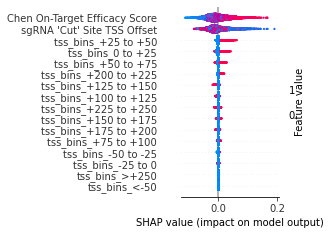

In [69]:
summary_legacy(shap_values_model, X, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=50)
gpp.savefig('../figure/shapval_rs2_tss.pdf', dpi=300)

# Check the most optimal prediction using Gilbert

In [28]:
X_gilbert = X
y_gilbert = y

In [29]:
X_gilbert['Crispri Seq + Target Score'] = model.predict(X_gilbert)
X_gilbert.reset_index(inplace=True)

In [30]:
X_val_pre_y_gilbert = pd.merge(gilbert2014_rs3, X_gilbert, 
                               on = list(set(gilbert2014_rs3.columns) & set(X_gilbert.columns)))

In [31]:
#X_val_pre_y_gilbert['reverse gamma'] = X_val_pre_y_gilbert['avg_gamma']*-1

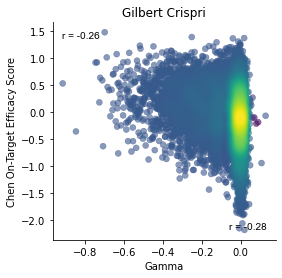

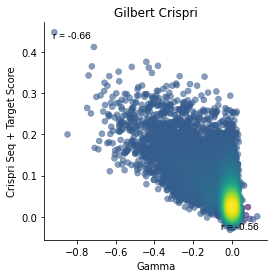

In [32]:
#obs_vals = [ 'avg_gamma', 'reverse gamma']
obs_vals = [ 'avg_gamma', 'avg_gamma']
scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_gilbert, obs_vals, scores, author='Gilbert', obs_meteric = 'Gamma')

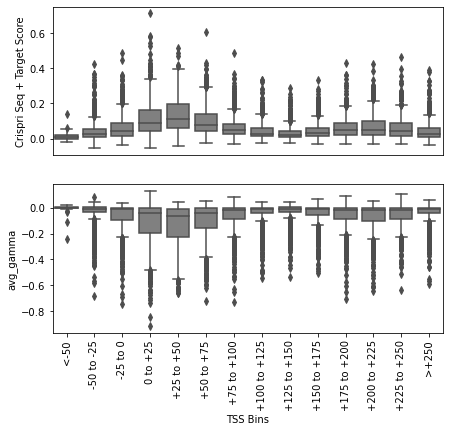

In [17]:
y_axis_gilbert = ["Crispri Seq + Target Score", 'avg_gamma']
tss_plot(X_val_pre_y_gilbert,y_axis_gilbert)

In [33]:
gilbert_performance = corr_pval_table(X_val_pre_y_gilbert, metric = 'gamma')

In [34]:
gilbert_performance

,bin,corr_rs3,p_val_corr_rs3,corr_seq_target,p_val_corr_seq_target
0,<-50,-0.356719,9.475101e-02,-0.176877,4.194563e-01
1,-50 to -25,-0.223628,8.775065e-10,-0.407371,9.395985e-31
2,-25 to 0,-0.236031,3.668072e-12,-0.463198,3.656959e-46
3,0 to +25,-0.268912,9.070488e-19,-0.577497,5.509777e-94
4,+25 to +50,-0.380375,4.365975e-32,-0.630770,3.877330e-100
5,+50 to +75,-0.377657,2.879616e-33,-0.598084,2.340673e-92
6,+75 to +100,-0.282004,1.275281e-16,-0.530636,2.141120e-61
7,+100 to +125,-0.252137,1.325435e-13,-0.482728,4.480577e-50
8,+125 to +150,-0.184255,6.874567e-08,-0.425238,1.975668e-38
9,+150 to +175,-0.255465,7.064837e-14,-0.483502,5.082496e-50


In [35]:
corr_gilbert = pd.melt(gilbert_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

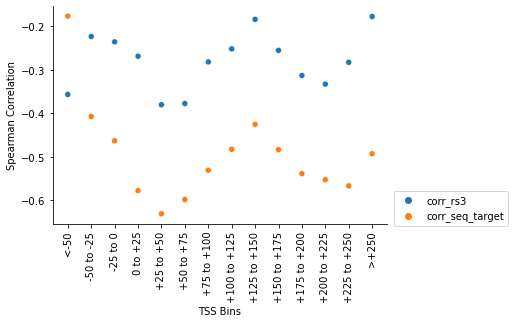

In [36]:
sns.scatterplot(data=corr_gilbert, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/gilbert_spearman_tss_box_plot.pdf', dpi=300)


# Test on Horlbeck 2016_sept

In [37]:
test_dataset_horlbeck = pd.read_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')


#### Add TSS bins binary

In [38]:
test_dataset_horlbeck = test_dataset_horlbeck.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_horlbeck = tssbin_binary(test_dataset_horlbeck)

#### Define X and Y 

In [39]:
test_dataset_horlbeck_X = test_dataset_horlbeck[x_variable]
test_dataset_horlbeck_X = test_dataset_horlbeck_X.set_index('sgRNA Context Sequence')    
y = test_dataset_horlbeck['avg_lfc'] *-1

#### Predicted

In [40]:
test_dataset_horlbeck_X['Crispri Seq + Target Score'] = model.predict(test_dataset_horlbeck_X)
test_dataset_horlbeck_X.reset_index(inplace=True)

In [41]:
X_val_pre_y_horlbeck = pd.merge(test_dataset_horlbeck, test_dataset_horlbeck_X, 
                       on = list(set(test_dataset_horlbeck.columns) & set(test_dataset_horlbeck_X.columns)))

In [42]:
#X_val_pre_y_horlbeck['reverse lfc'] = X_val_pre_y_horlbeck['avg_lfc']*-1

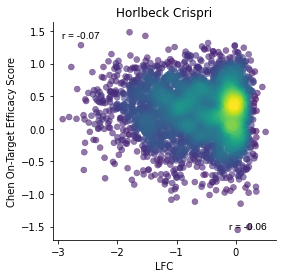

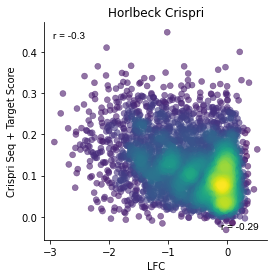

In [43]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_horlbeck, obs_vals_h, scores, author='Horlbeck', obs_meteric = 'LFC')

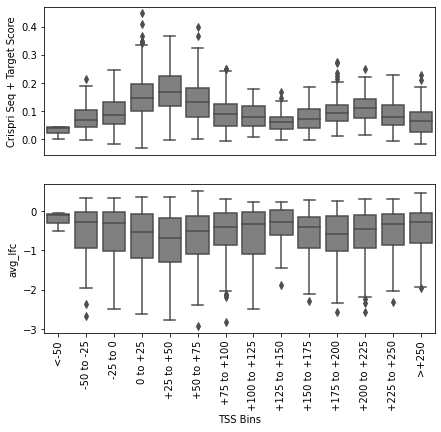

In [44]:
y_axis_horlbeck = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_horlbeck,y_axis_horlbeck, dataname='horlbeck')

In [45]:
horlbeck_performance = corr_pval_table(X_val_pre_y_horlbeck, metric = 'lfc')
corr_horlbeck = pd.melt(horlbeck_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

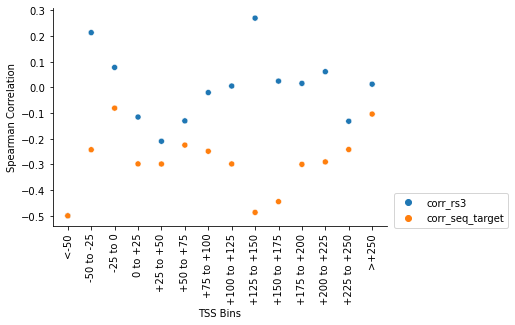

In [46]:
sns.scatterplot(data=corr_horlbeck, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/horlbeck_spearman_tss_box_plot.pdf', dpi=300)


# Sanson et al

In [47]:
test_dataset_sanson = pd.read_csv('../data/sanson_2018/sanson2018_activity.csv')


In [48]:
test_dataset_sanson = test_dataset_sanson.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_sanson= tssbin_binary(test_dataset_sanson)

In [49]:
sum(test_dataset_sanson['sgRNA \'Cut\' Site TSS Offset'] <= -50)

0

In [50]:
test_dataset_sanson['tss_bins_<-50'] = 0

In [51]:
test_dataset_sanson_X = test_dataset_sanson[x_variable]
test_dataset_sanson_X = test_dataset_sanson_X.set_index('sgRNA Context Sequence')    
y = test_dataset_sanson['avg_lfc']*-1

In [52]:
test_dataset_sanson_X['Crispri Seq + Target Score'] = model.predict(test_dataset_sanson_X)
test_dataset_sanson_X.reset_index(inplace=True)

In [53]:
X_val_pre_y_sanson = pd.merge(test_dataset_sanson, test_dataset_sanson_X, 
                              on = list(set(test_dataset_sanson.columns) & set(test_dataset_sanson_X.columns)))

In [54]:
#X_val_pre_y_sanson['reverse lfc'] = X_val_pre_y_sanson['avg_lfc']*-1

In [55]:
X_val_pre_y_sanson.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr().unstack().iloc[:,1]


Target Gene Symbol
AAMP        0.425196
AARS1       0.602423
AARS2      -0.711449
AASDHPPT    0.997268
AATF       -0.901133
              ...   
ZNRD2      -0.921489
ZPR1       -0.695650
ZRANB1     -0.487843
ZWILCH      0.811734
ZZZ3        0.999992
Name: (avg_lfc, Crispri Seq + Target Score), Length: 1461, dtype: float64

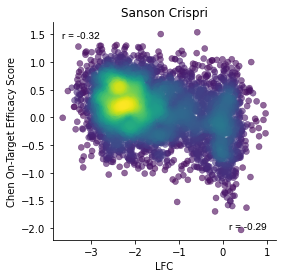

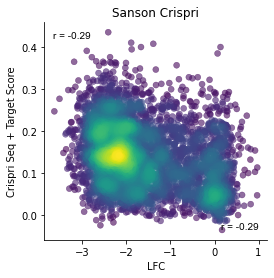

In [57]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_sanson, obs_vals_h, scores, author='Sanson', obs_meteric = 'LFC')

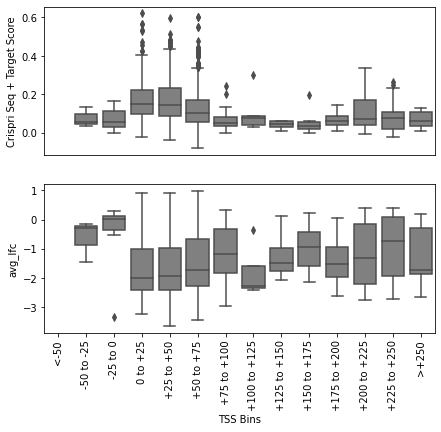

In [40]:
y_axis_sanson = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_sanson,y_axis_sanson, dataname = 'sanson')

In [58]:
sanson_performance = corr_pval_table(X_val_pre_y_sanson, metric = 'lfc')
corr_sanson = pd.melt(sanson_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

In [62]:
X_val_pre_y_sanson['tss_bins'].value_counts()

+50 to +75      1968
+25 to +50      1951
0 to +25         256
+75 to +100       47
+200 to +225      35
+225 to +250      33
+175 to +200      14
>+250              8
-25 to 0           7
+150 to +175       6
+100 to +125       5
+125 to +150       4
-50 to -25         3
Name: tss_bins, dtype: int64

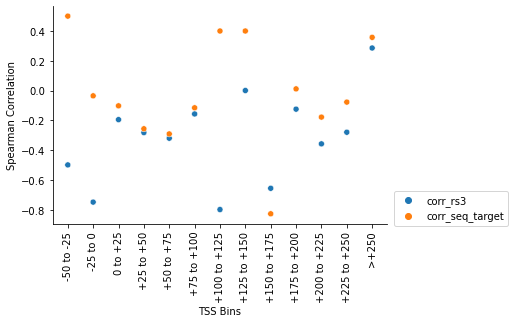

In [59]:
sns.scatterplot(data=corr_sanson, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/sanson_spearman_tss_box_plot.pdf', dpi=300)


In [64]:
# anaysis

In [116]:
gene_symbol = pd.DataFrame(X_val_pre_y_sanson['Target Gene Symbol'].value_counts()).reset_index()
gene_symbol = gene_symbol[gene_symbol['Target Gene Symbol'] >= 3]
gene_3 = X_val_pre_y_sanson[X_val_pre_y_sanson['Target Gene Symbol'].isin(gene_symbol['index'])]

In [117]:
gene_corr_rs3 = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Chen On-Target Efficacy Score']].corr(method = 'spearman').unstack()
gene_corr_rs3.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3 = pd.DataFrame(gene_corr_rs3.iloc[:,1]).reset_index()

In [118]:
gene_corr_rs3_target = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_rs3_target.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3_target = pd.DataFrame(gene_corr_rs3_target.iloc[:,1]).reset_index()

In [119]:
gene_corr_scores = gene_3.groupby('Target Gene Symbol')[['Chen On-Target Efficacy Score','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_scores.columns = ['Correlation_Val1_Val1', 'Correlation_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_scores = pd.DataFrame(gene_corr_scores.iloc[:,1]).reset_index()


In [120]:
gene_corr = pd.merge(pd.merge(gene_corr_rs3, gene_corr_rs3_target, on = 'Target Gene Symbol'), gene_corr_scores, on = 'Target Gene Symbol')

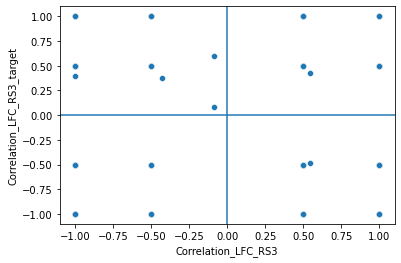

In [127]:
sns.scatterplot(data=gene_corr, x="Correlation_LFC_RS3", y="Correlation_LFC_RS3_target")
plt.axvline(0, 0,2)
plt.axhline(0, 0,2)

<AxesSubplot:xlabel='Correlation_RS3_target'>

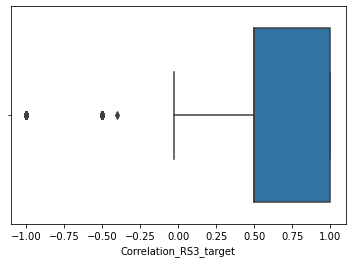

In [122]:
sns.boxplot(x=gene_corr["Correlation_RS3_target"] )

In [136]:
gene_corr[(gene_corr['Correlation_LFC_RS3'] < 0) & (gene_corr['Correlation_LFC_RS3_target']>0)]

,Target Gene Symbol,Correlation_LFC_RS3,Correlation_LFC_RS3_target,Correlation_RS3_target
1,AARS1,-0.5,0.5,0.5
5,ABCB7,-0.5,0.5,0.5
13,ACTR10,-0.5,0.5,-1.0
14,ACTR1A,-0.5,0.5,-1.0
23,ALDOA,-0.5,0.5,0.5
...,...,...,...,...
1391,ZBTB11,-1.0,0.5,-0.5
1392,ZBTB17,-0.5,0.5,0.5
1393,ZC3H18,-0.5,0.5,0.5
1403,ZNF408,-1.0,0.5,-0.5
